In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D
from keras.models import Model

from sklearn.metrics import mean_absolute_percentage_error


#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark") 

np.random.seed(42)
tf.random.set_seed(42)

2024-05-09 17:05:22.359285: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### CNN's for Time-series forecast: Airline Passenger data 
---------
We will build a Convolutional Neural Network to predict airline passenger data using 3 different supervised methods:

1. Supervised one step forecast 
2. Incremental, multi-step forecast
3. Multi-output, multi-step forecasting

In [4]:
# get data 

!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2024-05-09 16:18:05--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: 'airline_passengers.csv'

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2024-05-09 16:18:06 (7.27 MB/s) - 'airline_passengers.csv' saved [2036/2036]



In [2]:
df = pd.read_csv('airline_passengers.csv', index_col=0, parse_dates = True)

df['LogPassengers']=np.log(df['Passengers'])

# differenced Log passegers 

df['DiffLogPassengers'] = df['LogPassengers'].diff()

df.head()



,Passengers,LogPassengers,DiffLogPassengers
Month,,,
1949-01-01,112,4.718499,NaN
1949-02-01,118,4.770685,0.052186
1949-03-01,132,4.882802,0.112117
1949-04-01,129,4.859812,-0.022990
1949-05-01,121,4.795791,-0.064022


In [3]:
N_test = 12
train, test = df.iloc[:-N_test], df.iloc[-N_test:]

# booleand indexing 

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [4]:
# Prepare a supervised data set using T last vals to predict the next 

series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10 
X = []
Y = []

for t in range(len(series)-T):

    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)

print(f'Shape of X: {X.shape}', f'Shape of Y:{Y.shape}')

Shape of X: (133, 10, 1) Shape of Y:(133,)


In [5]:
# Test and train split for the supervised data set X and Y 

X_train, y_train = X[:-N_test], Y[:-N_test]
X_test, y_test = X[-N_test:], Y[-N_test:]

In [6]:
# CNN 

i = Input(shape = (T, 1))

x = Conv1D(16, 3, activation = 'relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1)(x)

model = Model(i,x)

In [7]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 8, 16)          │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 32)          │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# compile and fit 

model.compile(loss = 'mse', optimizer = 'adam')

result = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test))

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0132 - val_loss: 0.0101
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0117 - val_loss: 0.0095
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0110 - val_loss: 0.0089
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0103 - val_loss: 0.0085
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0098 - val_loss: 0.0082
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0093 - val_loss: 0.0076
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0089 - val_loss: 0.0072
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0085 - val_loss: 0.0069
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080 - val_loss: 0.0066
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0076 - val_loss: 0.0063
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0071 - val_loss: 0.0059
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067 - val_lo

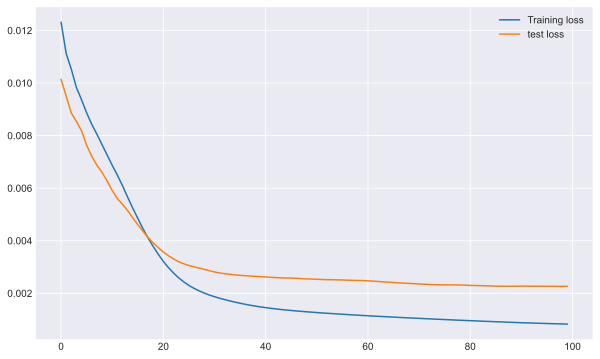

In [9]:
fig, axes = plt.subplots(figsize = (10,6))

axes.plot(result.history['loss'], label = 'Training loss')
axes.plot(result.history['val_loss'], label = 'test loss')

axes.grid()
axes.legend()

In [10]:
# First T+1 values are not predictable since we differenced the Log Passenger data 

train_idx[:T+1] = False

In [11]:
# get training and test predictions and store them

pred_train = model.predict(X_train).flatten()
pred_test = model.predict(X_test).flatten()

df.loc[train_idx, 'CNN_train_p'] = pred_train
df.loc[test_idx, 'CNN_test_p'] = pred_test

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


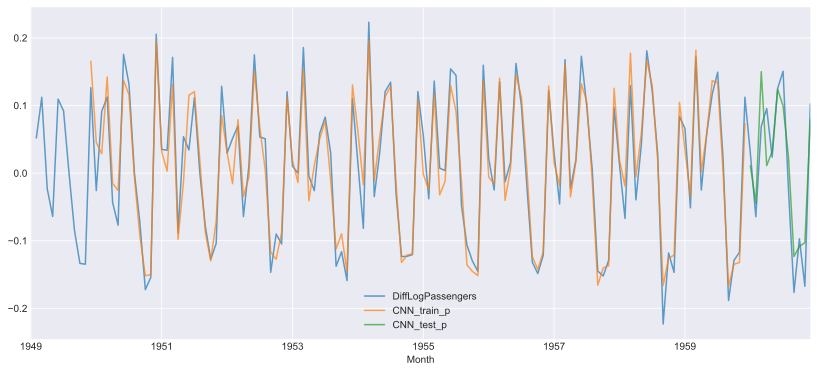

In [12]:
# Plot predictions vs data 

fig, axes = plt.subplots(figsize = (14,6))

p_cols = df.columns.to_list()

df[p_cols[-3:]].plot(ax = axes, alpha = 0.7)

axes.grid()

In [13]:
# Compute the un-differenced predictions 

df['LogPassengers_Shifted'] = df['LogPassengers'].shift(1)

prev = df['LogPassengers_Shifted']

# 1 - step forecast, recall that we modified train_idx setting first T+1 vals to False

df.loc[train_idx, '1s_train_pred'] = prev[train_idx] + pred_train

df.loc[test_idx, '1s_test_pred'] = prev[test_idx] + pred_test

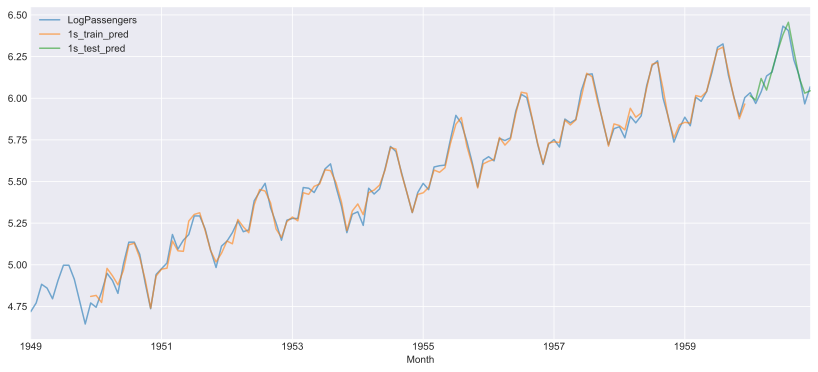

In [14]:
# Plot actual predictions 

fig, axes = plt.subplots(figsize = (14,6))

cols = ['LogPassengers', '1s_train_pred', '1s_test_pred']

df[cols].plot(ax= axes, alpha = 0.6)

axes.grid()

In [15]:
# multi-step incremental forecast 

ms_preds = []

# first test input 

last_x = X_test[0]

while len(ms_preds)< N_test:
    
    pred = model.predict(last_x.reshape(1,-1, 1))[0]

    # update the predictions list 

    ms_preds.append(pred)

    # make the new input 

    last_x = np.roll(last_x, -1)
    last_x[-1] = pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


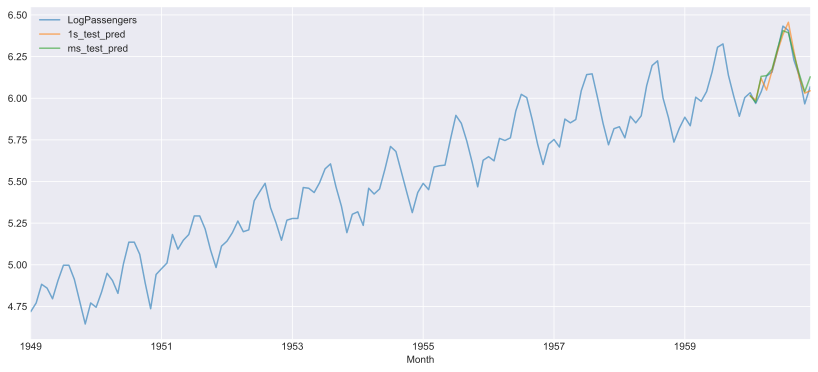

In [16]:
# save multi-step forecast to df and plot with respect to 1-step test forecasts 

last_train = train.iloc[-1]['LogPassengers'] # Last known train value 

df.loc[test_idx, 'ms_test_pred'] = last_train + np.cumsum(ms_preds)

fig, axes = plt.subplots(figsize = (14,6))

df[['LogPassengers', '1s_test_pred', 'ms_test_pred']].plot(ax = axes, alpha = 0.6)

axes.grid()

Multistep forecast looks pretty good, at least as good as the 1-step or even better to capture the peaks.

In [17]:
# Prepare multi-output supervised dataset 

Tx = T
Ty = N_test

X = []
Y = []

for t in range(len(series)- Tx- Ty + 1):

    x = series[t:t + Tx]
    X.append(x)

    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)


X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)

print(f'X shape: {X.shape}', f'Y shape: {Y.shape}')

X shape: (122, 10, 1) Y shape: (122, 12)


In [18]:
# train- test split 

X_train_m, y_train_m  = X[:-1], Y[:-1]

X_test_m, y_test_m = X[-1:], Y[-1:] # last entry in the X and Y will be the test set

In [19]:
# CNN multi-output forecast

i = Input(shape = (Tx, 1))

x = Conv1D(16, 3, activation = 'relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)

model_mo = Model(i,x)

In [20]:
# compile and fit 

model_mo.compile(loss = 'mse', optimizer = 'adam')

result_mo = model_mo.fit(X_train_m, y_train_m, epochs = 200, validation_data = (X_test_m, y_test_m))

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0117 - val_loss: 0.0119
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0113 - val_loss: 0.0115
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0111 - val_loss: 0.0114
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0110 - val_loss: 0.0113
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0109 - val_loss: 0.0112
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0108 - val_loss: 0.0112
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0106 - val_loss: 0.0112
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0105 - val_loss: 0.0112
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0104 - val_loss: 0.0112
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0102 - val_lo

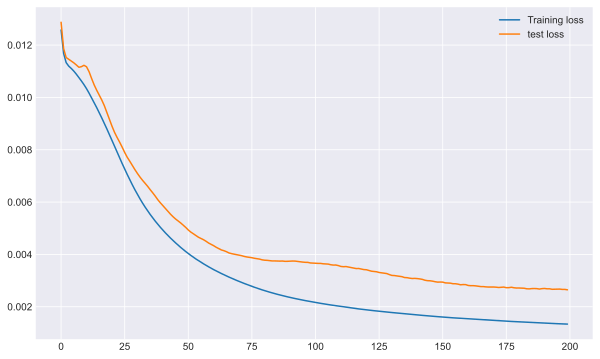

In [21]:
fig, axes = plt.subplots(figsize = (10,6))

axes.plot(result_mo.history['loss'], label = 'Training loss')
axes.plot(result_mo.history['val_loss'], label = 'test loss')

axes.grid()
axes.legend()

In [22]:
# get predictions 

pred_train_mo = model_mo.predict(X_train_m)

pred_test_mo = model_mo.predict(X_test_m)

pred_train_mo.shape, pred_test_mo.shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


((121, 12), (1, 12))

In [23]:
# indexing predictions, for the train set we will treat them as one step prediction and simply grab the first column 
# we can do so as we use 1,...10, to predict 11,...,22 and then use 2,...,11 to predict, 12,...,23 rd vals and so on
# so the 0th column of each row corresponds to one step prediction for the training set 
# this is a valid approach because the predictions closer to the current time would be expected to be more accurate 

pred_train = pred_train_mo[:,0]

pred_test = pred_test_mo[0]

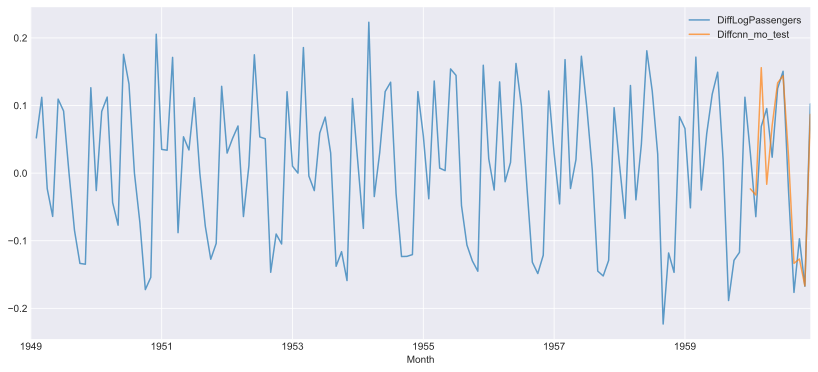

In [24]:
df.loc[test_idx, 'Diffcnn_mo_test'] = pred_test

fig, axes = plt.subplots(figsize = (14,6))

cols = ['DiffLogPassengers', 'Diffcnn_mo_test']

df[cols].plot(ax = axes, alpha = 0.7)

axes.grid()

In [25]:
# save multi-output forecasts 

df.loc[test_idx, 'mo_test_pred'] = last_train + np.cumsum(pred_test)

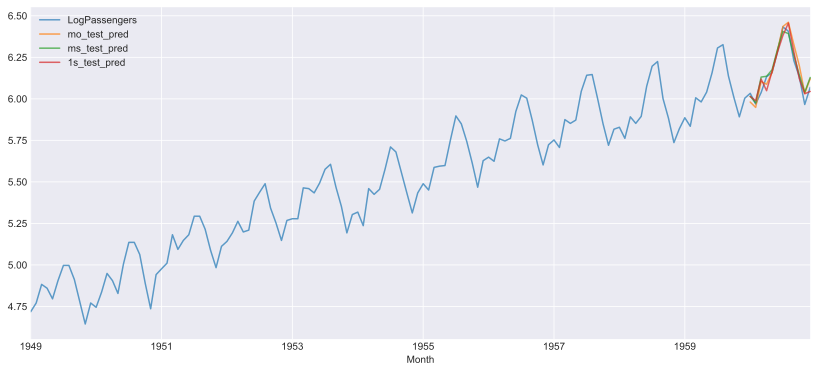

In [26]:
# And plot 

fig, axes = plt.subplots(figsize = (14,6))
cols = ['LogPassengers', 'mo_test_pred', 'ms_test_pred', '1s_test_pred']

df[cols].plot(ax = axes, alpha = 0.7)

axes.grid()

In [27]:
# lets compare their MAPEs

test_lpass = df.iloc[-N_test:]['LogPassengers']

mape_ms = mean_absolute_percentage_error(test_lpass, df.loc[test_idx, 'ms_test_pred'])
mape_mo = mean_absolute_percentage_error(test_lpass, df.loc[test_idx, 'mo_test_pred'])

print(f'Multi-step method MAPE: {mape_ms:.3f}\n',f"Multi-output method MAPE: {mape_mo:.3f}")

Multi-step method MAPE: 0.005
 Multi-output method MAPE: 0.007


Further checks and improvements that can be implemented: 

- Try without differencing and logging 
- More past lags to consider? 
- Walk forward valdiation to optimize the hyperparameters